# Part 3: Serving
In this part we will user MLRun's **serving runtime** to deploy our trained models from the previous stage a `Voting Ensemble` using **max vote** logic.  
We will also use MLRun's **Feature store** to receive the online **Feature Vector** we define in the preveious stage.

We will:
- Define a model class to load our models, run preprocessing and predict on the data
- Define Voting Ensemble function on top of our models
- Test the serving function locally using our `mock server`
- Deploy the function to the cluster and test it live

<img src="../docs/_static/images/feature_store_demo_diagram.png" width="600px" />

## Environment Setup

Since our work is done in a this project scope, we will first want to define the project itself for all our MLRun work in this notebook.

In [1]:
from dotenv import load_dotenv

load_dotenv('env.txt')

True

In [ ]:
import mlrun
project, _ = mlrun.set_environment(project='fsdemo', user_project=True)

## Define Model Class
- Load models
- Predict from the FS Online service via the `patient_id` key

In [2]:
# nuclio: start-code

In [3]:
from cloudpickle import load
import numpy as np
import mlrun
import os

class ClassifierModel(mlrun.serving.V2ModelServer):
    
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model('.pkl')
        self.model = load(open(model_file, 'rb'))
        
        # Setup FS Online service
        self.feature_service = mlrun.feature_store.get_online_feature_service('patient-deterioration')
        
        # Get feature vector statistics for imputing
        self.feature_stats = self.feature_service.vector.get_stats_table()
        
    def preprocess(self, body: dict, op) -> list:
        # Get patient feature vector 
        # from the patient_id given in the request
        vectors = self.feature_service.get([{'patient_id': patient_id} for patient_id in body['inputs']])
        
        # Impute inf's in the data to the feature's mean value
        # using the collected statistics from the Feature store
        feature_vectors = []
        for fv in vectors:
            new_vec = []
            for f, v in fv.items():
                if np.isinf(v):
                    new_vec.append(self.feature_stats.loc[f, 'mean'])
                else:
                    new_vec.append(v)
            feature_vectors.append(new_vec)
            
        # Set the final feature vector as our inputs
        # to pass to the predict function
        body['inputs'] = feature_vectors
        return body

    def predict(self, body: dict) -> list:
        """Generate model predictions from sample"""
        feats = np.asarray(body['inputs'])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()

In [4]:
# nuclio: end-code

## Define Serving Function
- Gather ClassifierModel code from this notebook
- Define `VotingEnsemble` - Max-Vote based ensemble
- Add downloaded models to the ensemble

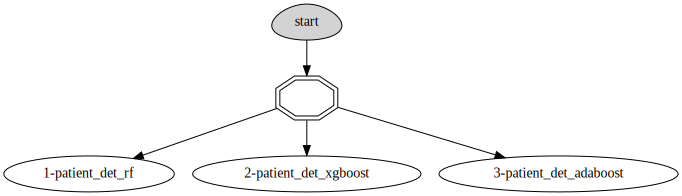

In [5]:
# Create the serving function from our code above
fn = mlrun.code_to_function('patient-prediction', kind='serving', image="mlrun/mlrun")

# Set the Voting Ensemble as our router
fn.set_topology('router', 'mlrun.serving.VotingEnsemble', name='PatientDeterioration')

# Add the three previously trained models to the ensemble
models_dir = os.path.abspath('models')
for name in ['1-patient_det_rf', '2-patient_det_xgboost', '3-patient_det_adaboost']:
    fn.add_model(name, class_name="ClassifierModel", model_path=f"store://artifacts/{project}/training_model:latest")
    
# Plot the ensemble configuration
fn.spec.graph.plot()

## Test the server locally

In [6]:
# Create a mock server from the serving function
server = fn.to_mock_server()

> 2021-05-06 15:32:30,709 [info] model 1-patient_det_rf was loaded
> 2021-05-06 15:32:30,963 [info] model 2-patient_det_xgboost was loaded
> 2021-05-06 15:32:31,260 [info] model 3-patient_det_adaboost was loaded
> 2021-05-06 15:32:31,261 [info] Loaded ['1-patient_det_rf', '2-patient_det_xgboost', '3-patient_det_adaboost']


**Test the server locally with a sample id**

In [7]:
resp = server.test('/v2/models/infer', body={'inputs': ['622-37-0180']})
resp

{'id': '3a543d0bf2c044faa4219f0db21c3218',
 'model_name': [0],
 'outputs': [0],
 'model_version': 'v1'}

## Deploy the function to the cluster (using Nuclio) and test it 

In [8]:
# Enable MLRun's model monitoring  
fn.set_tracking()

# Add the system mount to the function so
# it will have access to our models
fn.apply(mlrun.mount_v3io()).apply(mlrun.v3io_cred())

# Deploy the function to the cluster
fn.deploy()

> 2021-05-06 15:32:31,370 [info] Starting remote function deploy
2021-05-06 15:32:31  (info) Deploying function
2021-05-06 15:32:31  (info) Building
2021-05-06 15:32:31  (info) Staging files and preparing base images
2021-05-06 15:32:31  (info) Building processor image
2021-05-06 15:32:35  (info) Build complete
2021-05-06 15:32:45  (info) Function deploy complete
> 2021-05-06 15:32:45,264 [info] function deployed, address=default-tenant.app.yh30.iguazio-c0.com:32093


'http://default-tenant.app.yh30.iguazio-c0.com:32093'

**Test the function on the cluster using the `invoke` mechanism**

In [9]:
import json
fn.invoke('/v2/models/infer', body={'inputs': ['622-37-0180']})

{'id': 'e1a269b4-d9b6-44a5-ad50-9da72db63e1e',
 'model_name': [0],
 'outputs': [0],
 'model_version': 'v1'}

In [10]:
import json
fn.invoke(path='/v2/models/infer', body=json.dumps({'inputs': ['622-37-0180']}))

{'id': 'c5bc3178-c7f3-4c31-8978-4d909312ef3e',
 'model_name': [0],
 'outputs': [0],
 'model_version': 'v1'}